In [82]:
import os
from itertools import islice

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [155]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [156]:
NUMBERS_COUNT = 5000

### Table

In [157]:
notebook_path = os.path.abspath("main.ipynb")

table = os.path.join(os.path.dirname(notebook_path), "data/numbers.txt")

def read_numbers(filename: str, count: int) -> set[int]:
    numbers = set()
    with open(filename) as file: 
        line_num = 0

        for l in islice(file, line_num, None):
            numbers.update(set(l.split(" ")[1:-1]))
            if len(numbers) >= count + 1:
                break
            line_num += 1

        numbers.remove("") 
        numbers = list(numbers)[:count]

    return numbers

def table_rand(filename: str, count: int=5000) -> tuple[np.ndarray]:
    numbers = read_numbers(filename, 3*count)

    one_digit = np.array([int(i)%10 for i in numbers[:count]])
    two_digits = np.array([int(i)%90 + 10 for i in numbers[count:count*2]])
    three_digits = np.array([int(i)%900 + 100 for i in numbers[count*2:3*count]])

    return one_digit, two_digits, three_digits

### Algorytmic

In [158]:
# Linear congruent method

# one of
# a          c          m
# 4096       150889     714025
# 36261      66037      312500
# 84589      45989      217728

# 1664525    1013904223 2^32
# 22695477   1          2^32
# 1103515245 12345      2^31

class RNG:
    def __init__(self, seed: int = 10):
        self.a, self.c, self.m = 84589, 45989, 217728
        self.current = seed
        
    def get_number(self, low=0, high=100) -> int:
        self.current = (self.a * self.current + self.c) % self.m
        return int(low + self.current % (high - low))

def alg_rand(seed: int=10, count: int=5000) -> tuple[np.ndarray]:
    random = RNG(seed)
    
    one_digit = np.array([random.get_number(0, 10) for i in range(count)])
    two_digits = np.array([random.get_number(10, 100) for i in range(count)])
    three_digits = np.array([random.get_number(100, 1000) for i in range(count)])
    
    return  one_digit, two_digits, three_digits

### Main

In [159]:
tbl = table_rand(table, NUMBERS_COUNT)

alg = alg_rand(seed=150, count=NUMBERS_COUNT)

io = [1, 9, 1, 9, 1, 9, 1, 9, 1, 9]

In [160]:
data = pd.DataFrame()

data["алг. 0-9"] = alg[0]
data["алг. 10-99"] = alg[1]
data["алг. 100-999"] = alg[2]
data["табл. 0-9"] = tbl[0]
data["табл. 10-99"] = tbl[1]
data["табл. 100-999"] = tbl[2]

data[::500]

,алг. 0-9,алг. 10-99,алг. 100-999,табл. 0-9,табл. 10-99,табл. 100-999
0,5,37,791,5,75,451
500,5,53,675,2,88,355
1000,3,45,319,4,80,940
1500,1,13,335,4,24,367
2000,3,29,219,5,77,664
2500,9,93,619,7,97,279
3000,9,25,599,2,15,268
3500,7,95,807,2,77,515
4000,7,51,415,3,16,851
4500,1,73,611,3,18,662


### $\chi^2$

In [161]:
def calc_hi(cnt: np.ndarray, n: int) -> int:     
    r = 0
    for i in range(len(cnt)):
        if i == len(cnt) - 1:
            p = (1/np.math.factorial(i+1))
        else:
            p = (1/np.math.factorial(i+1) - 1/np.math.factorial(i+1+1))

        r += cnt[i]**2 / p
    
    r = r / n - n

    return r

### Monotonicity criterion

In [162]:
def monotonicity_criterion(arr: np.ndarray):
    tabs = np.zeros(6, dtype='int64')
    
    i, length = 0, 1
    while i < len(arr):
        if (i == len(arr) - 1) or (arr[i] > arr[i+1]):
            tabs[5 if length >= 6 else length-1] += 1

            i, length = i+1, 0

        i += 1
        length += 1

    n = sum(i * tabs[i] for i in range(len(tabs)))
    return calc_hi(tabs, n)

In [163]:
data = pd.DataFrame()
data.loc["ввод", "0-9"] = monotonicity_criterion(io)
data.loc["ввод", "10-99"] = data.loc["ввод", "100-999"] = "-"

data.loc["алг.", "0-9"] = monotonicity_criterion(alg[0])
data.loc["алг.", "10-99"] = monotonicity_criterion(alg[1])
data.loc["алг.", "100-999"] = monotonicity_criterion(alg[2])
data.loc["табл.", "0-9"] = monotonicity_criterion(tbl[0])
data.loc["табл.", "10-99"] = monotonicity_criterion(tbl[1])
data.loc["табл.", "100-999"] = monotonicity_criterion(tbl[2])

data

,0-9,10-99,100-999
ввод,34.000000,-,-
алг.,1585.342147,1459.579608,1055.301611
табл.,666.491240,1228.049094,1185.293633


### Plots

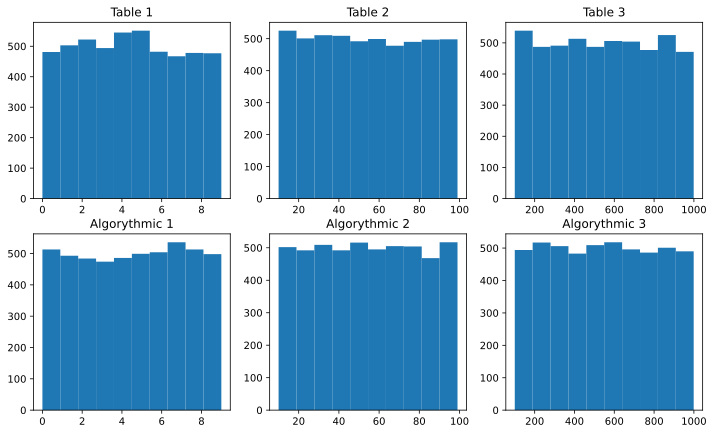

In [164]:
fig, axis = plt.subplots(2, 3, figsize=(12,7))

for i in range(len(tbl)):    
    axis[0][i].set_title(f"Table {i+1}")
    axis[0][i].hist(tbl[i])

for i in range(len(alg)):    
    axis[1][i].set_title(f"Algorythmic {i+1}")
    axis[1][i].hist(alg[i])

plt.show()